<a href="https://colab.research.google.com/github/lelumiEdirisinghe/Lelumi_Final_Year_Project/blob/main/CountryClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, entropy
import seaborn as sns
import os
import sys
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from sklearn.metrics.pairwise import euclidean_distances
import geopandas as gpd

In [ ]:
file_path= "/content/drive/My Drive/CountryClustering/population_pyramid.csv"
df=pd.read_csv(file_path)


Data **Cleaning**

Extract Only the countries

In [ ]:
df=df[~df['Country'].str.isupper()]

In [ ]:
non_countries = [
    'AFRICA', 'ASIA', 'Caribbean', 'Central America', 'Central Asia', 'EUROPE',
    'Eastern Africa', 'Eastern Asia', 'Eastern Europe', 'LATIN AMERICA AND THE CARIBBEAN',
    'Least developed countries', 'Less developed regions', 'Less developed regions, excluding China',
    'Less developed regions, excluding least developed countries', 'Melanesia', 'Micronesia',
    'Middle Africa', 'More developed regions', 'NORTHERN AMERICA', 'Northern Africa',
    'Northern Europe', 'OCEANIA', 'Other non-specified areas', 'Polynesia', 'South America',
    'South-Central Asia', 'South-Eastern Asia', 'Southern Africa', 'Southern Asia',
    'Southern Europe', 'Sub-Saharan Africa', 'WORLD', 'Western Africa', 'Western Asia',
    'Western Europe'
]

In [ ]:
df=df[~df['Country'].isin( non_countries) ]

In [ ]:
df['Country'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Australia/New Zealand', 'Austria', 'Azerbaijan',
       'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus',
       'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia (Plurinational State of)', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon',
       'Canada', 'Central African Republic', 'Chad', 'Channel Islands',
       'Chile', 'China', 'China, Hong Kong SAR', 'China, Macao SAR',
       'Colombia', 'Comoros', 'Congo', 'Costa Rica', "Côte d'Ivoire",
       'Croatia', 'Cuba', 'Curaçao', 'Cyprus', 'Czech Republic',
       'Democratic Republic of the Congo',
       "Dem. People's Republic of Korea", 'Denmark', 'Djibouti',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia',

Clean the years column

In [ ]:
df = df[df['Year'] != 2022 ]

In [ ]:
df['Year'].unique()

array([1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020])

Clean the Age Column

In [ ]:
df['Age'] = df['Age'].replace( { '9-May': '5-9', '14-Oct': '10-14' })

In [ ]:
df['Age'].unique()

array(['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39',
       '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74',
       '75-79', '80-84', '85-89', '90-94', '95-99', '100+'], dtype=object)

Add Total Column

In [ ]:
df['Total'] = df['M'] + df['F']

Reduce the Age Groups to One Principle Component Per Year

In [ ]:
# 5. Prepare Data for PCA (Pivot)
# We need a matrix where rows are (Country, Year) and columns are Age Groups
df_pivot = df.pivot_table(index=['Country', 'Year'], columns='Age', values='Total')

In [ ]:
# Ensure age columns are in the correct chronological order
age_order = ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39',
             '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74',
             '75-79', '80-84', '85-89', '90-94', '95-99', '100+']
df_pivot = df_pivot[age_order]

In [ ]:
# 6. Normalize to Percentages
# This ensures PCA captures age *structure* (proportions), not population size.
df_pct = df_pivot.div(df_pivot.sum(axis=1), axis=0)

In [ ]:
# 7. Apply PCA
# Standardize the features (Mean=0, Variance=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_pct)

In [ ]:
# Initialize PCA to reduce to 1 component
pca = PCA(n_components=1)
pc1_scores = pca.fit_transform(X_scaled)

In [ ]:
# 8. Store Results in a new DataFrame
results = df_pct.reset_index()[['Country', 'Year']].copy()
results['Age_Structure_PC1'] = pc1_scores

In [ ]:
# Display the results
print("Explained Variance Ratio:", f"{pca.explained_variance_ratio_[0]:.2%}")
print("\nFirst 5 rows of the result:")
print(results.head())

Explained Variance Ratio: 66.87%

First 5 rows of the result:
Age      Country  Year  Age_Structure_PC1
0    Afghanistan  1950          -2.497983
1    Afghanistan  1960          -2.786814
2    Afghanistan  1970          -3.052697
3    Afghanistan  1980          -3.438149
4    Afghanistan  1990          -3.951779


Interpretation of Age_Structure_PC1

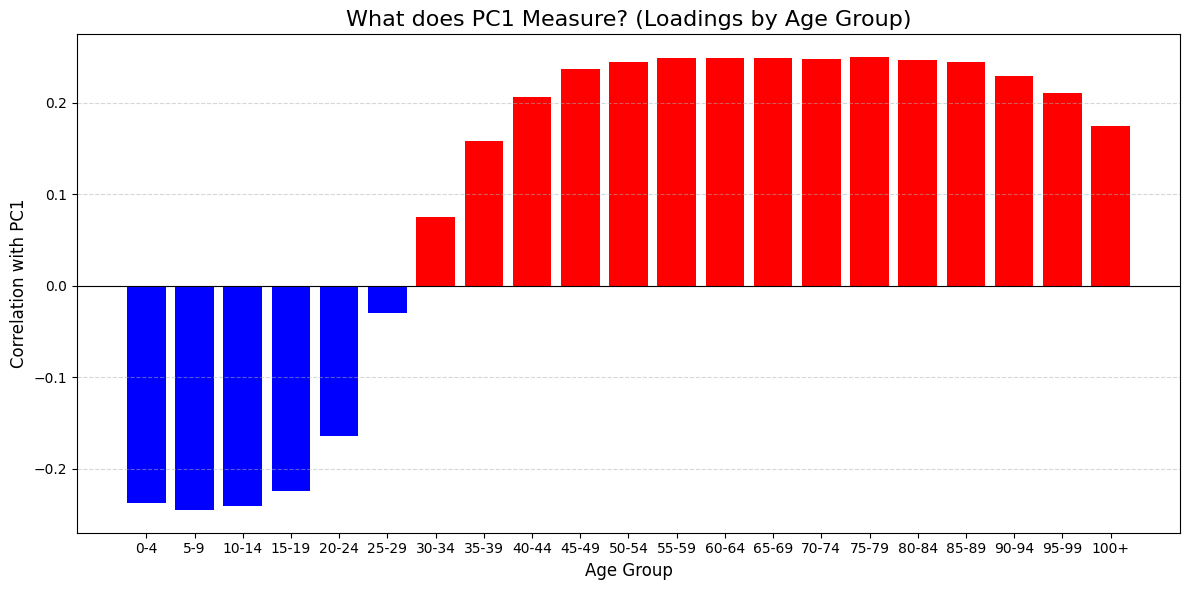

In [ ]:
# 2. Extract Loadings (The "DNA" of PC1)
# pca.components_ contains the loadings. We transpose (.T) it to make it a column.
loadings = pd.DataFrame(pca.components_.T, index=df_pct.columns, columns=['PC1_Loading'])

# 3. Plotting
plt.figure(figsize=(12, 6))

# Assign colors: Blue for Negative (Young), Red for Positive (Old)
colors = ['red' if x > 0 else 'blue' for x in loadings['PC1_Loading']]

plt.bar(loadings.index, loadings['PC1_Loading'], color=colors)
plt.axhline(0, color='black', linewidth=0.8) # Add a zero line
plt.title('What does PC1 Measure? (Loadings by Age Group)', fontsize=16)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Correlation with PC1', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add text labels for clarity
plt.text(2, -0.15,"",
         ha='center', color='blue', fontweight='bold')
plt.text(16, 0.15,"",
         ha='center', color='red', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# 5. Create the Loadings Table
# Transpose components to get Shape: (n_features, n_components)
loadings_table = pd.DataFrame(pca.components_.T, index=age_order, columns=['PC1_Loading'])

# 6. Display the table
print(loadings_table)

       PC1_Loading
0-4      -0.237935
5-9      -0.245182
10-14    -0.240952
15-19    -0.223998
20-24    -0.163998
25-29    -0.029883
30-34     0.074745
35-39     0.158503
40-44     0.206278
45-49     0.237120
50-54     0.244890
55-59     0.249128
60-64     0.249119
65-69     0.248817
70-74     0.247720
75-79     0.249910
80-84     0.246986
85-89     0.244577
90-94     0.229525
95-99     0.210077
100+      0.174082


PC1 acts as a population aging index, where negative scores indicate a demographic dominated by youth (under 30) and positive scores indicate a demographic dominated by older adults and seniors (over 30).

# Visualize the Evolution of PC1 for Different Countries

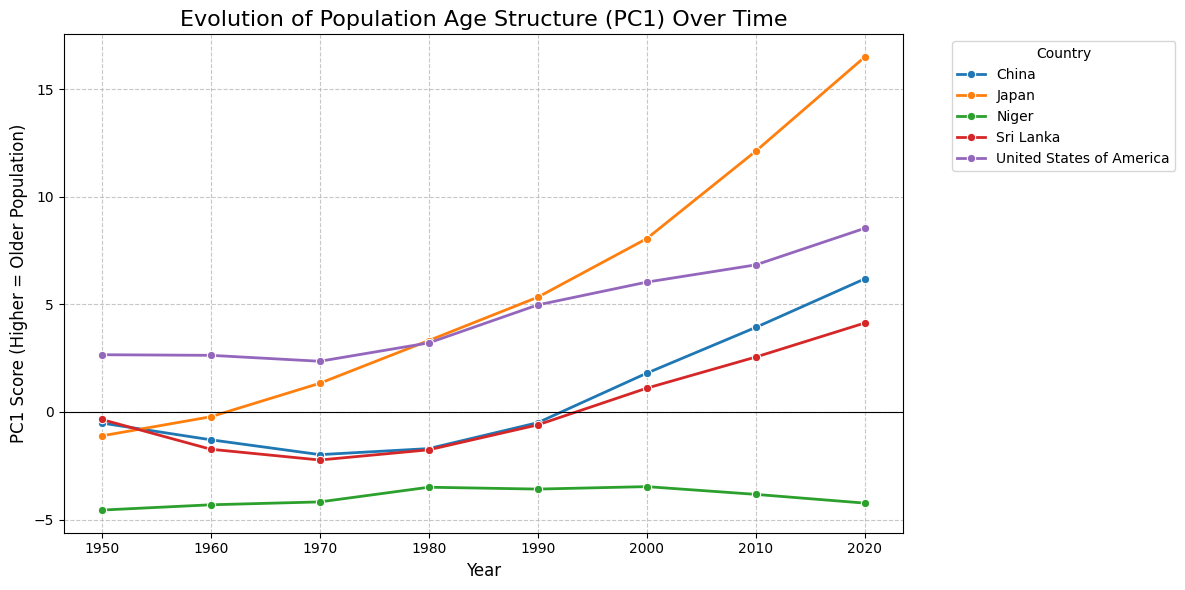

In [ ]:
# 5. Filter for Selected Countries
# Feel free to change this list to any countries you are interested in!
selected_countries = ['Sri Lanka', 'Japan', 'China', 'United States of America', 'Niger']
df_plot = results[results['Country'].isin(selected_countries)]

# 6. Visualization
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_plot, x='Year', y='Age_Structure_PC1', hue='Country', marker='o', linewidth=2)

plt.title('Evolution of Population Age Structure (PC1) Over Time', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('PC1 Score (Higher = Older Population)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axhline(0, color='black', linewidth=0.8, linestyle='-') # Reference line

plt.tight_layout()
plt.show() # Display the plot

The chart illustrates a stark demographic divergence: while Japan and the USA show a steep climb toward an aging population (high PC1), Niger remains persistently young (low/negative PC1), and Sri Lanka and China exhibit a sharp upward trajectory since the 1980s, reflecting their rapid transition from a youthful to an aging society.

# Functional Data Analysis

In [ ]:
# 1. Define Common Grid for Evaluation
# This ensures all country functions are comparable (vectors of same length)
common_grid = np.linspace(1950, 2020, 71)

functional_data = []
valid_countries = []

# 2. Loop through ALL unique countries
all_countries = results['Country'].unique()

for country in all_countries:
    # Get country data
    country_data = results[results['Country'] == country].sort_values('Year')
    x_data = country_data['Year'].values
    y_data = country_data['Age_Structure_PC1'].values

    # Fit Spline (smoothing)
    # k=3 (Cubic), s=1 (Smoothing factor)
    if len(x_data) > 3:
        spline = UnivariateSpline(x_data, y_data, k=3, s=1)

        # Evaluate on the common grid
        y_smooth = spline(common_grid)

        functional_data.append(y_smooth)
        valid_countries.append(country)

# 3. Create Final Matrix for Clustering
df_functional = pd.DataFrame(functional_data, index=valid_countries, columns=common_grid)

print(f"Approximated functions for {len(df_functional)} countries.")

Approximated functions for 201 countries.


In [ ]:
# 3. Functional Approximation & Visualization
selected_countries = ['Sri Lanka', 'Japan', 'China', 'United States of America', 'Niger']
colors = ['purple', 'red', 'orange', 'green', 'blue']

plt.figure(figsize=(12, 7))

# Create a dense grid of years for plotting the smooth lines
x_smooth = np.linspace(1950, 2020, 200)

<Figure size 1200x700 with 0 Axes>

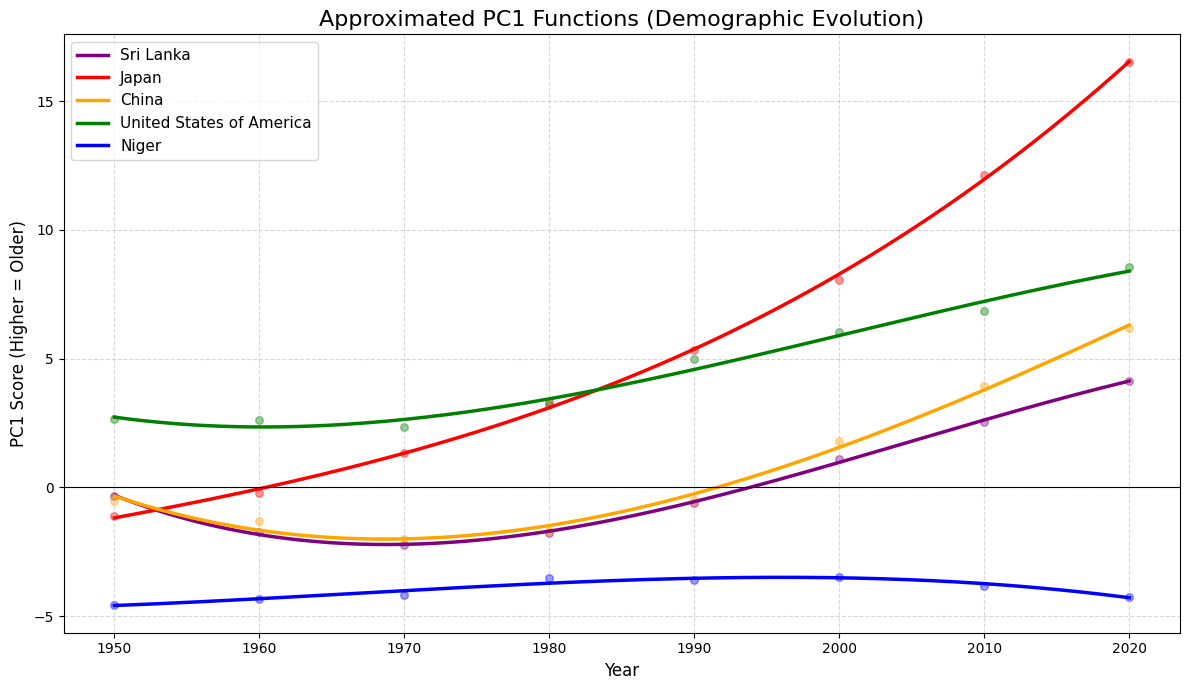

In [ ]:
# 3. Functional Approximation & Visualization
selected_countries = ['Sri Lanka', 'Japan', 'China', 'United States of America', 'Niger']
colors = ['purple', 'red', 'orange', 'green', 'blue']

plt.figure(figsize=(12, 7))

# Create a dense grid of years for plotting the smooth lines
x_smooth = np.linspace(1950, 2020, 200)

for i, country in enumerate(selected_countries):
    # Extract discrete data for the country
    country_data = results[results['Country'] == country].sort_values('Year')
    x_data = country_data['Year'].values
    y_data = country_data['Age_Structure_PC1'].values

    # Fit B-Spline (Functional Approximation)
    # k=3: Cubic Spline
    # s=1: Smoothing factor (allows the curve to be smooth rather than jaggedly connecting every point)
    spline = UnivariateSpline(x_data, y_data, k=3, s=1)

    # Evaluate the spline on the dense grid
    y_smooth = spline(x_smooth)

    # Plot the Original Data Points (Dots)
    plt.scatter(x_data, y_data, color=colors[i], alpha=0.4, s=30)

    # Plot the Approximated Function (Line)
    plt.plot(x_smooth, y_smooth, color=colors[i], linewidth=2.5, label=country)

# Chart Formatting
plt.title('Approximated PC1 Functions (Demographic Evolution)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('PC1 Score (Higher = Older)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.5)
plt.axhline(0, color='black', linewidth=0.8) # Zero line for reference

plt.tight_layout()
plt.show()

# Probabilistic K-Means Clustering

Converged at iteration 22
Probabilistic Clustering Results (First 15 Countries):
                       Prob_Young  Prob_Transition  Prob_Old Most_Likely_Stage
Afghanistan              0.941139         0.049016  0.009845             Young
Albania                  0.060470         0.896576  0.042954        Transition
Algeria                  0.690813         0.285732  0.023454             Young
Angola                   0.941093         0.048984  0.009923             Young
Antigua and Barbuda      0.018405         0.972157  0.009438        Transition
Argentina                0.148666         0.569790  0.281544        Transition
Armenia                  0.102490         0.709428  0.188082        Transition
Aruba                    0.124318         0.573510  0.302172        Transition
Australia                0.014751         0.038028  0.947221               Old
Australia/New Zealand    0.017045         0.044517  0.938438               Old
Austria                  0.027777         0.053610

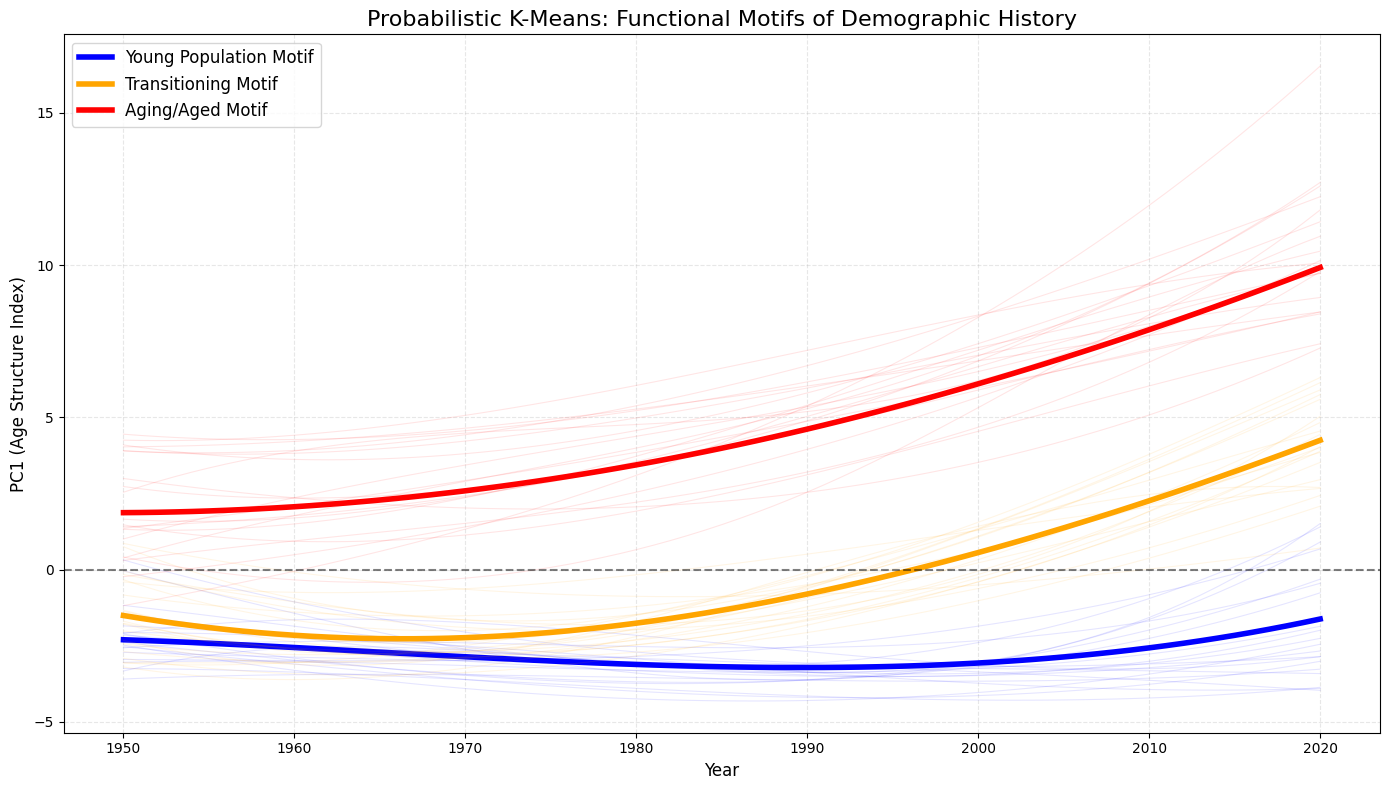

In [ ]:
# ==============================================================================
# 1. SETUP DATA
# ==============================================================================
# Ensure df_functional is a numpy matrix for speed
# df_functional comes from your previous step (Rows: Countries, Cols: Years)
X = df_functional.values
countries = df_functional.index
years = df_functional.columns.astype(float)

# ==============================================================================
# 2. PROBABILISTIC K-MEANS ALGORITHM (Implementation)
# ==============================================================================

class ProbabilisticKMeans:
    def __init__(self, n_clusters=3, m=2.0, max_iter=100, tol=1e-4):
        """
        n_clusters: Number of clusters (K)
        m: Fuzzifier parameter (m > 1). Controls how "fuzzy" the clusters are.
           m=2 is standard. Higher m = fuzzier.
        """
        self.n_clusters = n_clusters
        self.m = m
        self.max_iter = max_iter
        self.tol = tol

    def fit(self, X):
        n_samples, n_features = X.shape

        # 1. Initialize Membership Matrix (U) randomly
        # Rows = Samples, Cols = Clusters
        # Constraint: Sum of probabilities for each sample must be 1
        np.random.seed(42)
        U = np.random.rand(n_samples, self.n_clusters)
        U = U / U.sum(axis=1, keepdims=True)

        self.centroids = np.zeros((self.n_clusters, n_features))

        for iteration in range(self.max_iter):
            U_prev = U.copy()

            # --- UPDATE CENTROIDS ---
            # C_j = Sum( (u_ij)^m * x_i ) / Sum( (u_ij)^m )
            # The centroid is the weighted average of all curves, weighted by membership prob
            um = U ** self.m
            for j in range(self.n_clusters):
                numerator = np.sum(um[:, j].reshape(-1, 1) * X, axis=0)
                denominator = np.sum(um[:, j])
                self.centroids[j] = numerator / denominator

            # --- UPDATE MEMBERSHIP PROBABILITIES ---
            # u_ij = 1 / Sum_k ( (d_ij / d_ik) ^ (2/(m-1)) )

            # Calculate distances from every point to every centroid
            # shape: (n_samples, n_clusters)
            dists = euclidean_distances(X, self.centroids)

            # Avoid division by zero
            dists = np.maximum(dists, 1e-10)

            # Calculate power term: 2 / (m - 1)
            power = 2.0 / (self.m - 1)

            # Vectorized update
            # (d_ij)^(2/(m-1))
            d_pow = dists ** power

            # Denominator: Sum over all clusters k for each sample i
            # We want matrix calculation: for each cell (i,j), we need sum_k(d_ij/d_ik)
            # Easier approach: U_ij = 1 / sum_k ( (d_ij / d_ik) ^ power )
            #                       = 1 / ( d_ij^power * sum_k (1 / d_ik^power) )

            inv_d_pow = 1.0 / d_pow
            sum_inv_d_pow = np.sum(inv_d_pow, axis=1, keepdims=True)

            U = inv_d_pow / sum_inv_d_pow

            # Check for convergence (Frobenius norm of change in U)
            if np.linalg.norm(U - U_prev) < self.tol:
                print(f"Converged at iteration {iteration}")
                break

        self.U = U
        return self

# ==============================================================================
# 3. EXECUTE CLUSTERING
# ==============================================================================

# We use K=3 to capture the three main stages: Young, Transitioning, Aged
pkmeans = ProbabilisticKMeans(n_clusters=3, m=2.0)
pkmeans.fit(X)

# Get Results
probabilities = pkmeans.U
centroids = pkmeans.centroids

# ==============================================================================
# 4. OUTPUT TABLE
# ==============================================================================

# Create DataFrame
df_probs = pd.DataFrame(probabilities, index=countries, columns=['Cluster_A', 'Cluster_B', 'Cluster_C'])

# Identify the "Primary" cluster (highest probability)
df_probs['Primary_Cluster'] = df_probs.idxmax(axis=1)

# Sort the columns so Cluster 1 is "Young" and Cluster 3 is "Old" for readability
# We check the mean value of the centroid at the final year (2020)
centroid_final_vals = centroids[:, -1] # Last point of each curve
sorted_indices = np.argsort(centroid_final_vals) # Index of Low -> High

# Reorder Centroids and Probability Columns
sorted_centroids = centroids[sorted_indices]
sorted_probs = df_probs.iloc[:, sorted_indices] # Reorder A, B, C
sorted_probs.columns = ['Prob_Young', 'Prob_Transition', 'Prob_Old']
sorted_probs['Most_Likely_Stage'] = sorted_probs.idxmax(axis=1).str.replace('Prob_', '')

print("Probabilistic Clustering Results (First 15 Countries):")
print(sorted_probs.head(15))

# ==============================================================================
# 5. VISUALIZATION
# ==============================================================================

plt.figure(figsize=(14, 8))

# Define colors for the sorted clusters
colors = ['blue', 'orange', 'red']
labels = ['Young Population Motif', 'Transitioning Motif', 'Aging/Aged Motif']

# Plot the Centroids (The "Average Shapes")
for i in range(3):
    plt.plot(years, sorted_centroids[i], color=colors[i], linewidth=4, label=labels[i])

    # Optional: Plot faint lines for countries that strongly belong to this cluster
    # to show the variance
    cluster_members = sorted_probs[sorted_probs.iloc[:, i] > 0.6].index
    member_data = df_functional.loc[cluster_members].values

    # Plot a subset to avoid clutter
    if len(member_data) > 0:
        # Sample max 20 lines
        idx = np.random.choice(len(member_data), min(len(member_data), 20), replace=False)
        for curve in member_data[idx]:
            plt.plot(years, curve, color=colors[i], alpha=0.1, linewidth=0.8)

plt.title('Probabilistic K-Means: Functional Motifs of Demographic History', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('PC1 (Age Structure Index)', fontsize=12)
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

sorted_probs.to_csv('country_cluster_probabilities.csv')

In [ ]:
print("--- COUNTRIES BY DEMOGRAPHIC CLUSTER ---\n")
cluster_types = ['Young', 'Transition', 'Old']
for cluster in cluster_types:
    # Filter for countries belonging to this specific cluster
    subset = sorted_probs[sorted_probs['Most_Likely_Stage'] == cluster]

    # Get country names (index) and sort them alphabetically
    country_list = subset.index.tolist()
    country_list.sort()

    # Output the list
    print(f"### {cluster} Population Motif ({len(country_list)} countries)")
    print(", ".join(country_list))
    print("\n" + "="*50 + "\n")

--- COUNTRIES BY DEMOGRAPHIC CLUSTER ---

### Young Population Motif (91 countries)
Afghanistan, Algeria, Angola, Bangladesh, Belize, Benin, Bhutan, Bolivia (Plurinational State of), Botswana, Burkina Faso, Burundi, Cabo Verde, Cambodia, Cameroon, Central African Republic, Chad, Comoros, Congo, Côte d'Ivoire, Democratic Republic of the Congo, Djibouti, Egypt, Equatorial Guinea, Eritrea, Ethiopia, Fiji, Gabon, Gambia, Ghana, Guatemala, Guinea, Guinea-Bissau, Guyana, Haiti, Honduras, Iran (Islamic Republic of), Iraq, Jordan, Kenya, Kiribati, Lao People's Democratic Republic, Lesotho, Liberia, Libya, Madagascar, Malawi, Maldives, Mali, Mauritania, Mayotte, Micronesia (Fed. States of), Mongolia, Morocco, Mozambique, Namibia, Nepal, Nicaragua, Niger, Nigeria, Oman, Pakistan, Papua New Guinea, Paraguay, Philippines, Rwanda, Samoa, Sao Tome and Principe, Saudi Arabia, Senegal, Sierra Leone, Solomon Islands, Somalia, South Africa, South Sudan, State of Palestine, Sudan, Swaziland, Syrian Arab 

# World Map

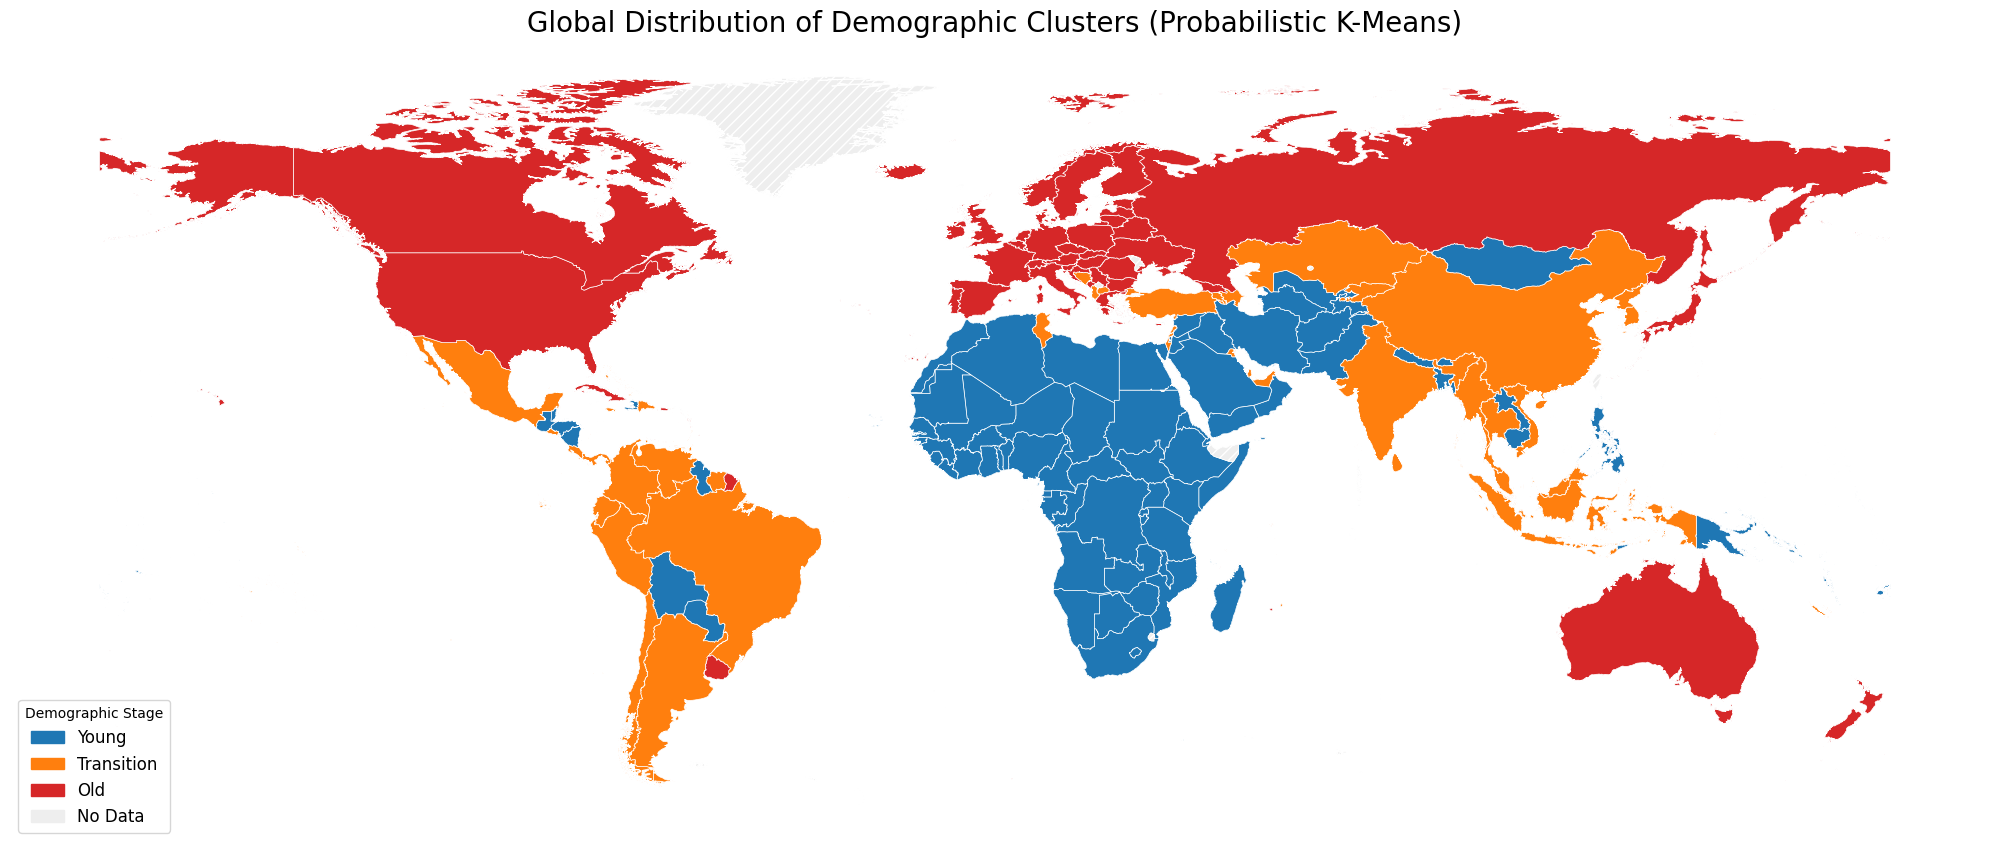

In [ ]:
import requests
import tempfile
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Note: If you don't have geopandas installed, uncomment the line below:
# !pip install geopandas

# 1. Load World Map Data from a stable GeoJSON source
# Using a well-known GeoJSON file of world countries as a more reliable alternative.
url = 'https://raw.githubusercontent.com/datasets/geo-countries/main/data/countries.geojson'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}

try:
    response = requests.get(url, headers=headers, stream=True)
    response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)

    # Read the GeoJSON directly into a GeoDataFrame
    world = gpd.read_file(response.text)

except requests.exceptions.RequestException as e:
    print(f"Error downloading world map data: {e}")
    # Re-raise to stop execution and indicate error
    raise
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    raise

# Remove Antarctica to improve the map ratio (if present in this dataset)
world = world[~world['name'].isin(["Antarctica", "Fr. S. Antarctic Lands", "Seven seas (open ocean)"])]

# 2. Prepare Cluster Data
# Reset index to turn the Country index into a column for merging
# We assume 'sorted_probs' is the DataFrame from your previous clustering step
map_data = sorted_probs.reset_index()
# Ensure the column is named 'Country' (it might be 'index' after reset)
if 'Country' not in map_data.columns:
    map_data = map_data.rename(columns={'index': 'Country'})

# 3. Handle Naming Inconsistencies for Merging
# Create a mapping dictionary for common name differences
name_mapping = {
    'Bolivia': 'Bolivia (Plurinational State of)',
    'Palestine': 'State of Palestine',
    'Syria': 'Syrian Arab Republic',
    'South Korea': 'Republic of Korea',
    'North Korea': 'Dem. People\'s Republic of Korea',
    'Republic of the Congo': 'Congo',
    'Russia': 'Russian Federation',
    'Czechia': 'Czech Republic',
    'Vietnam': 'Viet Nam',
    'North Macedonia': 'TFYR Macedonia',
    'Laos': 'Lao People\'s Democratic Republic',
    'Iran': 'Iran (Islamic Republic of)',
    'Ivory Coast': 'Côte d\'Ivoire',
    'Republic of Serbia': 'Serbia',
    'East Timor': 'Timor-Leste',
    'Brunei': 'Brunei Darussalam',
    'Venezuela': 'Venezuela (Bolivarian Republic of)',
    'Hong Kong S.A.R.': 'China, Hong Kong SAR',
    'Macao S.A.R': 'China, Macao SAR',
    'The Bahamas': 'Bahamas'
}

# Apply the mapping to a new column in the GeoDataFrame for merging
world['name_for_merge'] = world['name'].replace(name_mapping)

# Merge Geometry with Data using the mapped names
world_merged = world.merge(map_data, left_on='name_for_merge', right_on='Country', how='left')

# 4. Visualization
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

# Define specific colors to match your previous charts (Young=Blue, Transition=Orange, Old=Red)
cluster_colors = {
    'Young': '#1f77b4',       # Blue
    'Transition': '#ff7f0e',  # Orange
    'Old': '#d62728'          # Red
}

# Plot each cluster
for cluster, color in cluster_colors.items():
    subset = world_merged[world_merged['Most_Likely_Stage'] == cluster]
    if not subset.empty:
        subset.plot(ax=ax, color=color, edgecolor='white', linewidth=0.5)

# Plot countries with missing data (grey)
missing = world_merged[world_merged['Most_Likely_Stage'].isna()]
if not missing.empty:
    missing.plot(ax=ax, color='#eeeeee', hatch='///', edgecolor='white', linewidth=0.5)

# Styling
ax.set_title('Global Distribution of Demographic Clusters (Probabilistic K-Means)', fontsize=20)

# Custom Legend to correctly display labels
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in cluster_colors.items()]
legend_patches.append(mpatches.Patch(color='#eeeeee', label='No Data'))
ax.legend(handles=legend_patches, title='Demographic Stage', loc='lower left', fontsize=12, frameon=True)
ax.set_axis_off() # Turn off lat/long axis numbers

plt.tight_layout()
plt.show()